# Rekonstruktion von Morse-Codes mithilfe von LSTM-Netwerken

Ziel dieses Projektes ist es, die Leerzeichen beziehungsweise die Pausen zwischen den Darstellungen einzelner Buchstaben im Morsecode mithilfe eines rekurrenten LSTM-Netzwerkes zu rekonstruieren. Obwohl durch das Weglassen der Leerzeichen im Prinzip Information verloren geht, ergeben meistens nur bestimmte Positionen der Leerzeichen sinnvolle Wörter.

In [12]:
import tensorflow as tf
import numpy as np

## Morse-Kodierung

Zuerst schreiben wir eine Funktion `to_morse`, die ein Wort in Morse-Code übersetzt

In [13]:
morse_code = {
    'A': '.-',     'B': '-...',   'C': '-.-.',   'D': '-..',    'E': '.',      'F': '..-.',
    'G': '--.',    'H': '....',   'I': '..',     'J': '.---',   'K': '-.-',    'L': '.-..',
    'M': '--',     'N': '-.',     'O': '---',    'P': '.--.',   'Q': '--.-',   'R': '.-.',
    'S': '...',    'T': '-',      'U': '..-',    'V': '...-',   'W': '.--',    'X': '-..-',
    'Y': '-.--',   'Z': '--..' }

In [14]:
def to_morse_word(word):
    word = word.upper()
    if not all([x in morse_code for x in word]):
        raise Exception("Wort enthält Zeichen außerhalb des englischen Alphabets")
    return ' '.join([morse_code[x] for x in word])
def to_morse(phrase):
    return 'X'.join([to_morse_word(word) for word in phrase.split(" ")])

Test der Funktion:

In [15]:
to_morse("SOS V")

'... --- ...X...-'

## Eingabe und Ausgabe des neuronalen Netzwerkes

Wir müssen uns zuerst fragen, wie die Ein- und Ausgabe des Netzwerkes kodiert sein soll. Wie alle neuronalen Netze besteht die Eingabe eines LSTM-Modells nicht aus Zeichen, sondern aus Gleitkommazahlen.

Die Eingabe soll ein Morse-Code sein. Da die Leerzeichen weggelassen wurden, besteht dieser nur aus zwei Zeichen. Ein häufiges Verfahren für die Kodierung kategorischer Daten ist das *one-hot encoding*. Die folgende Funktion implementiert diese Codierung der Eingabe, wobei die Leerzeichen im Morsecode automatisch weggelassen werden.

**Look-ahead** Es ist schwierig für das neuronale Netz, zu entscheiden, wo die Morse-Codes unterbrochen werden sollen, ohne wenigstens ein paar Zeichen vorwärts schauen zu können. Daher verschiebe ich einfach Ein- und Ausgabe mithilfe eines einstellbaren look-aheads gegeneinander. Anders gesagt, das neuronale Netz muss erst einige Zeichen später signalisieren, dass ein Leerzeichen eingefügt werden soll.

In [16]:
lookahead = 10

Die Eingabe wird als `float`-Array kodiert, damit man sie direkt ins neuronale Netzwerk einspeisen kann.

In [17]:
def encode_input(morse):
    encodings = { '.': [1, 0, 0], '-': [0, 1, 0], 'X': [0, 0, 1] }
    return np.array([encodings[x] for x in (morse #+ lookahead*"X" 
                                           )if x != ' ']).astype(float)

In [18]:
encode_input(to_morse("SOS"))

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Die Ausgabe des Netzwerkes möchte ich so machen, dass das Netz für jedes Eingabezeichen entscheiden soll, ob nach diesem Zeichen ein Leerzeichen wahrscheinlich ist. Die gewünschte Ausgabe ist also `1`, wenn auf ein Zeichen im ursprünglichen Morsecode ein Leerzeichen folgt, und sonst `0`. Für das letzte Zeichen macht es Sinn, `1` vorzuschreiben, da das Wortende ja auch ein Buchstabenende ist. Die folgende Funktion implementiert die gewünschte Ausgabe:

In [19]:
def compute_target(morse):
    return np.array(#lookahead*[0] + 
        [int((b == " ") | (b == "X")) for a,b in zip(morse[:-1], morse[1:]) if a != " "] + [1]).astype(float)

In [20]:
compute_target(to_morse("SOS"))

array([0., 0., 1., 0., 0., 1., 0., 0., 1.])

Bei "SOS" haben alle Buchstaben drei Zeichen, deshalb besteht die gewünscht Ausgabe aus drei gleichen Teilen.

## Trainings-Daten generieren

In [21]:
with open("filtered_words.txt", "r") as f:
    words = f.read()

In [22]:
assert all([x.upper() in morse_code or x == "\n" for x in words])

In [23]:
words = words.split("\n")[:-1]

In [24]:
def get_random_phrase(length):
    phrase = ""
    while len(phrase) < length:
        if phrase != "":
            phrase += " "
        phrase += words[np.random.randint(len(words))]
    return phrase
def make_training_data(length):
    phrase = get_random_phrase(length)
    morse = to_morse(phrase)
    inputs = encode_input(morse)
    targets = compute_target(morse)
    inputs = inputs[:length]
    targets = targets[:length]
    return inputs, targets

In [25]:
get_random_phrase(50)

'beneficial springfield subjects shapes thumbnail newest'

In [26]:
morse_all = [to_morse(w) for w in words]

In [27]:
np.amax([len(x) for x in morse_all])

59

In [28]:
words_all = np.zeros((len(words), 50 + lookahead, 3))
outs_all = np.zeros((len(words), 50 + lookahead, 1))

In [29]:
morse_all[1]

'.. -. ..-. --- .-. -- .- - .. --- -.'

In [30]:
for i in range(len(words)):
    c = morse_all[i]
    print(len(c), encode_input(c).shape)
    enc = encode_input(c)
    outs_all[i,lookahead:lookahead+enc.shape[0],0] = compute_target(c)
    words_all[i, :enc.shape[0]] = enc
    words_all[i, enc.shape[0]:] = [0,0,1]

11 (9, 3)
36 (26, 3)
28 (21, 3)
19 (14, 3)
28 (21, 3)
31 (24, 3)
27 (21, 3)
26 (21, 3)
33 (25, 3)
36 (28, 3)
27 (21, 3)
14 (11, 3)
21 (16, 3)
26 (21, 3)
20 (16, 3)
26 (21, 3)
27 (21, 3)
17 (13, 3)
29 (23, 3)
13 (9, 3)
27 (21, 3)
28 (21, 3)
34 (25, 3)
23 (17, 3)
15 (11, 3)
39 (27, 3)
14 (11, 3)
25 (18, 3)
36 (26, 3)
22 (16, 3)
14 (10, 3)
21 (16, 3)
17 (13, 3)
24 (18, 3)
29 (21, 3)
31 (23, 3)
16 (11, 3)
31 (24, 3)
15 (11, 3)
38 (29, 3)
17 (13, 3)
28 (21, 3)
22 (16, 3)
28 (21, 3)
23 (17, 3)
36 (28, 3)
30 (23, 3)
32 (24, 3)
18 (14, 3)
28 (21, 3)
29 (22, 3)
33 (25, 3)
32 (24, 3)
28 (21, 3)
31 (22, 3)
30 (23, 3)
10 (8, 3)
24 (17, 3)
32 (25, 3)
14 (10, 3)
27 (21, 3)
30 (23, 3)
17 (12, 3)
20 (16, 3)
38 (28, 3)
30 (22, 3)
30 (23, 3)
18 (14, 3)
20 (15, 3)
17 (14, 3)
29 (21, 3)
27 (21, 3)
32 (23, 3)
28 (21, 3)
17 (13, 3)
34 (25, 3)
25 (19, 3)
23 (18, 3)
28 (21, 3)
27 (21, 3)
28 (22, 3)
25 (18, 3)
28 (21, 3)
30 (23, 3)
27 (20, 3)
39 (29, 3)
23 (18, 3)
30 (22, 3)
10 (8, 3)
40 (30, 3)
27 (20, 3)
29 

In [31]:
words_all.shape, outs_all.shape

((4843, 60, 3), (4843, 60, 1))

## Trainings-Daten aus Text

In [32]:
with open("filtered_words.txt", "r") as f:
    text = f.read()
text = "".join([x for x in text if x == "\n" or x == " " or (x.upper() in morse_code)])
text = text.replace("\n", " ")
text = " ".join(text.split())

In [33]:
" ".join("abc def ghi".split())

'abc def ghi'

In [34]:
text[:500]

'has information business online services products product policy available copyright support info rights public books school through years privacy items company research university reviews games international ebay comments development details terms hotels using results education community states shipping women technology pages security members computer systems following download resources posts pictures personal including directory location government children usa students shopping sites profile'

## Morse-Dekodieren zum Testen

In [35]:
morse_inverse = { code: letter for letter, code in morse_code.items() }

## Möglichkeiten generieren

In [36]:
len(words)

4843

## Definition und Training des Modells

In [37]:
from tensorflow import keras
# Load the saved model
model = keras.models.load_model('ModellSmall.h5')

In [38]:
def morse_decode_word(with_spaces):
    codes = with_spaces.split(" ")
    return "".join([morse_inverse[x] if x in morse_inverse else "?" for x in codes])
def morse_decode(s):
    return " ".join([morse_decode_word(x) for x in s.split("X")])

In [39]:
def remove_spaces(s):
    return "".join([x for x in s if x != " "])

In [40]:
def insert_spaces(s_no_spaces, output=None):
    inp_encode = encode_input(s_no_spaces + lookahead*"X")
    if output is None:
        output = model(inp_encode.reshape(1,-1,3)).numpy()[0,:,0][lookahead:]
    with_spaces = ""
    for i in range(len(s_no_spaces)):
        char = s_no_spaces[i]
        with_spaces += char
        if output[i] > 0 and i < len(s_no_spaces) - 1 and s_no_spaces[i+1] != "X" and s_no_spaces[i] != "X":
            with_spaces += " "
    return with_spaces

In [41]:
morse_orig = to_morse_word("CAR")
print(morse_orig)

-.-. .- .-.


In [42]:
nospace = remove_spaces(morse_orig)
print(nospace)

-.-..-.-.


In [43]:
reconstructed = insert_spaces(nospace)
print(reconstructed)

-.-. .- .-.


In [44]:
morse_decode(reconstructed)

'CAR'

In [45]:
!pip install python-Levenshtein


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 61.8 MB/s eta 0:00:00


In [46]:
pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Average Levenshtein Distance: 4.54
Percentage of identical words: 7.37%
Original Word    Decoded Word      Levenshtein-Distanz
---------------  --------------  ---------------------
HAS              SIDE                                4
INFORMATION      INFORMATION                         0
BUSINESS         BUSINESS                            0
ONLINE           TOINIRE                             4
SERVICES         SERSTICH                            4
PRODUCTS         PRODUN?E                            3
PRODUCT          PRODUCT                             0
POLICY           POEDITRY                            4
AVAILABLE        RITLL?IDE                           7
COPYRIGHT        COAKWLWEIIT                         8


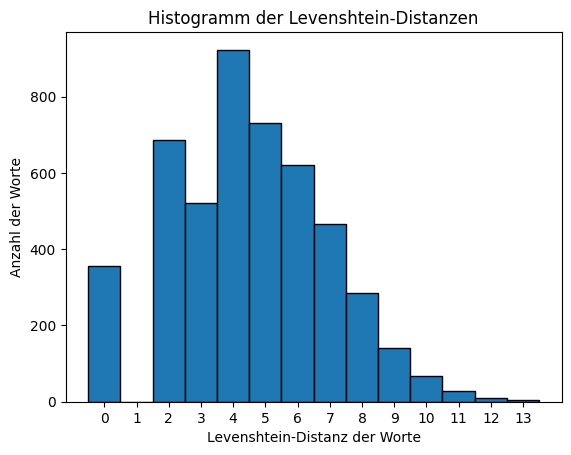

In [47]:
import Levenshtein as lev
import matplotlib.pyplot as plt
from tabulate import tabulate

def levenshtein_distance(words, decoded):
    distances = []
    word_pairs = []
    identical_count = 0
    
    for word, decoded_word in zip(words, decoded):
        distance = lev.distance(word, decoded_word)
        distances.append(distance)
        word_pairs.append((word, decoded_word, distance))
        
        if distance == 0:
            identical_count += 1

    identical_percentage = identical_count / len(words) * 100
    return distances, word_pairs, identical_percentage



with open('filtered_words.txt', 'r') as f:
    words = f.read().splitlines()

# take the first 1000 words from the file
words = [word.upper() for word in words]
decoded = []  # create an empty list to store the decoded plaintext

with open('morse_code.txt', 'w') as f:
    for word in words:
        morseorig = to_morse_word(word)
        nospace = remove_spaces(morseorig)
        reconstructed = insert_spaces(nospace)
        f.write(reconstructed + '\n')
        plaintext = morse_decode(reconstructed)
        decoded.append(plaintext)  # add the decoded plaintext to the list

distances, word_pairs, identical_percentage = levenshtein_distance(words, decoded)
print(f"Average Levenshtein Distance: {sum(distances) / len(distances):.2f}")
print(f"Percentage of identical words: {identical_percentage:.2f}%")

# Display the table
headers = ["Original Word", "Decoded Word", "Levenshtein-Distanz"]
print(tabulate(word_pairs[:10], headers=headers))
max_distance = max(distances)

# Create custom bins centered around the integers
bins = np.arange(-0.5, max_distance + 1.5, 1)

# Plot the histogram
plt.hist(distances, bins=bins, edgecolor='black')
plt.xlabel('Levenshtein-Distanz der Worte')
plt.ylabel('Anzahl der Worte')
plt.title('Histogramm der Levenshtein-Distanzen')
plt.xticks(np.arange(0, max_distance + 1, 1))  # Set the x-axis ticks to integer values
plt.show()